<a href="https://colab.research.google.com/github/vishwanaik15/ML_PROJECT-_-HWR/blob/main/Team5_HWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Term Project

Deep Learning:
Object Detection on images:  Handwriting Recognization

Dataset : Handwrirng Recognization(Dataset From Kaggle)

Name: Vishwa Naik (1001871311)
Name: Tirth Patel (1001869576)

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#  Load Dataset from Kaggle

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od


In [5]:
od.download("https://www.kaggle.com/landlord/handwriting-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vish15898
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:11<00:00, 114MB/s]


# Data Load and View

In [6]:
train = pd.read_csv('handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('handwriting-recognition/written_name_test_v2.csv')

In [7]:
print("Length of train data: ",len(train))
train.head()

Length of train data:  330961


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [9]:
print("Length of test data: ",len(test))
test.head()

Length of test data:  41370


,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [10]:
print("Length of valid data: ",len(valid))
valid.head()

Length of valid data:  41370


,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


##  View Train image data

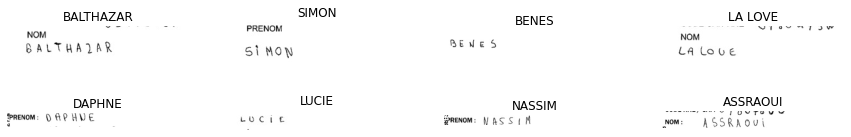

In [12]:
plt.figure(figsize=(15, 10))

for i in range(8):
    ax = plt.subplot(3, 4, i+1)
    image_dir = 'handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

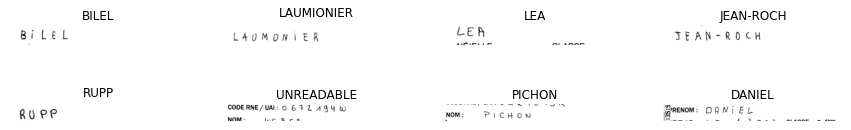

In [13]:
plt.figure(figsize=(15, 10))

for i in range(8):
    ax = plt.subplot(3, 4, i+1)
    image_dir = 'handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(valid.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Data Cleaning
   
   Using .isnull() : Find null values
   Using .dropna() : Drop null values.

In [14]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [15]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [16]:
train = train.dropna()
valid = valid.dropna()

In [17]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [18]:
print("Length of train data: ",len(train))
print("Length of valid data: ",len(valid))

Length of train data:  330396
Length of valid data:  41292


Dataset some images labeled as UNREADABLE .
Find those image and remove.

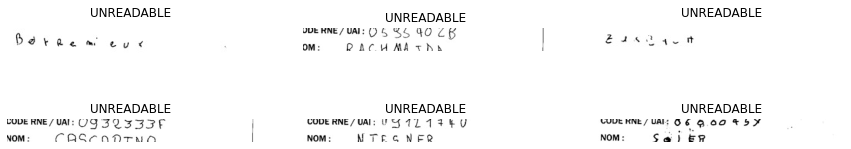

In [19]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

Remove UNREADABLE imaged.

In [20]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [21]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [22]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [23]:
train.shape

(330294, 2)

# Data Preprocessing

-Load image as grayscle (color ranges from 0 to 255 different shades varying from white to black).
-Reshape all the images .(Height 64 and Width 256).
-Image size set to 256 width and 64 height and small images padded with white pixels.
-Rotate Image clockwise to make image shape [x,y].
-Made a preprocess function to run on both train and valid images.

In [25]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model is trained on 15000 images and validate on 1500 images and will be tested on 30000

In [28]:
train_size = 20000
valid_size= 3000

In [29]:
train_x = []

for i in range(train_size):
    img_dir = 'handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [30]:
valid_x = []

for i in range(valid_size):
    img_dir = 'handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [31]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

# Preparing the labels

The lables are converted into numbers reprenting character in the training set 

In [51]:
alphabets_list = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
maximum_string_length = 24 
number_of_characters = len(alphabets_list) + 1 
number_of_timestamps = 64 


def label_to_number(label):
    label_number = []
    for character in label:
        label_number.append(alphabets_list.find(character))
        
    return np.array(label_number)

def number_to_label(number):
    vn = ""
    for character in number:
        if character == -1:  
            break
        else:
            vn+=alphabets[character]
    return vn

In [52]:
print("Check for a name (charater from number matrix): ")
data = 'BALTHAZAR'
print(data, '\n',label_to_number(data))

Check for a name (charater from number matrix): 
BALTHAZAR 
 [ 1  0 11 19  7  0 25  0 17]


In [54]:
train_y = np.ones([train_size, maximum_string_length]) * -1
train_label_length = np.zeros([train_size, 1])
train_input_length = np.ones([train_size, 1]) * (number_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_length[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_number(train.loc[i, 'IDENTITY'])   

In [77]:
valid_y = np.ones([valid_size, maximum_string_length]) * -1
valid_label_length = np.zeros([valid_size, 1])
valid_input_length = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_length[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_number(valid.loc[i, 'IDENTITY'])  

In [78]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_length : ',train_label_length[100], 
      '\ntrain_input_length : ', train_input_length[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_length :  [4.] 
train_input_length :  [62.]


# Model Building
CNN with 5 layers and then pass output to RNN.

In [80]:

input_dataset= Input(shape=(256, 64, 1), name='Input')
# Layer 1
x = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_dataset)  
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), name='max1')(x)
#Layer 2
x = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), name='max2')(x)
x = Dropout(0.3)(x)
# Layer 3
x = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(1, 2), name='max3')(x)
x = Dropout(0.3)(x)
# Layer 4
x = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(1, 2), name='max4')(x)
x = Dropout(0.3)(x)
# Layer 5
x = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(1, 2), name='max5')(x)
x = Dropout(0.3)(x)

# CNN to RNN
x = Reshape(target_shape=((64, 1024)), name='reshape')(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

## RNN
x = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(x)
x = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(x)

  ## OUTPUT
x = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(x)
y_pred = Activation('softmax', name='softmax')(x)

hwr_model = Model(inputs=input_dataset, outputs=y_pred)
hwr_model.summary()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_15 (Bat  (None, 256, 64, 32)      128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

#Loss Fuction

Here we have taken CTC loss fuction used in text recognization.
For our code we have made custom CTC loss function to take 4 input and output loss and then further used for traing and testing with our model.

In [81]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [82]:
labels = Input(name='ground_truth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss_output = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
hwr_model_final = Model(inputs=[input_dataset, labels, input_length, label_length], outputs=ctc_loss_output)

## Model train

For model trainng we will use Adam optimizer.Also added the keras callback funtion tp store the weights of best model considering validation loss.

In [83]:
epochs = 90
batch_size = 128
optimizer_name = 'Adam'

In [84]:
hwr_model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics=['accuracy'])
filepath="{}o-{}r-.hdf5".format(optimizer_name,str(epochs))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [85]:
# Train the model
history_model = hwr_model_final.fit(x=[train_x, train_y, train_input_length, train_label_length], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_length, valid_label_length], valid_output),
                epochs=epochs, batch_size=batch_size,callbacks=callbacks_list,verbose=1)

Epoch 1/90
157/157 [==============================] - ETA: 0s - loss: 26.3180 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 20.92569, saving model to Adamo-90r-.hdf5
157/157 [==============================] - 89s 515ms/step - loss: 26.3180 - accuracy: 0.0000e+00 - val_loss: 20.9257 - val_accuracy: 0.0000e+00
Epoch 2/90
157/157 [==============================] - ETA: 0s - loss: 20.2447 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 20.92569 to 20.85637, saving model to Adamo-90r-.hdf5
157/157 [==============================] - 76s 485ms/step - loss: 20.2447 - accuracy: 0.0000e+00 - val_loss: 20.8564 - val_accuracy: 0.0000e+00
Epoch 3/90
157/157 [==============================] - ETA: 0s - loss: 19.9619 - accuracy: 0.0000e+00
Epoch 00003: val_loss improved from 20.85637 to 20.23081, saving model to Adamo-90r-.hdf5
157/157 [==============================] - 76s 484ms/step - loss: 19.9619 - accuracy: 0.0000e+00 - val_loss: 20.2308 - val_accuracy: 0.0000e+00


The shape of output predictiion is (64,30)  

In [89]:
history_df = pd.DataFrame(history_model.history)
history_csv_file = 'history.csv'
with open(history_csv_file, mode='w') as f:
  history_df.to_csv(f)



# Model Training

#  Check The model Predication on Validation data

In [92]:
preds = hwr_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(number_to_label(decoded[i]))

In [93]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char/total_char*100))
print('Correct words predicted      : %.2f%%' %(correct/valid_size*100))

Correct characters predicted : 89.26%
Correct words predicted      : 75.50%


In [94]:
print(correct_char)

17565


In [95]:
print(correct)

2265


In [97]:
history_model.history

{'accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  9.999999747378752e-05,
  0.0038999998942017555,
  0.014800000004470348,
  0.033799998462200165,
  0.06759999692440033,
  0.10904999822378159,
  0.15320000052452087,
  0.18930000066757202,
  0.23090000450611115,
  0.27195000648498535,
  0.30090001225471497,
  0.3315500020980835,
  0.36010000109672546,
  0.38005000352859497,
  0.4076499938964844,
  0.42925000190734863,
  0.44519999623298645,
  0.4599500000476837,
  0.4812999963760376,
  0.4972499907016754,
  0.5084999799728394,
  0.5217499732971191,
  0.5346500277519226,
  0.5448499917984009,
  0.5522500276565552,
  0.5654000043869019,
  0.5734000205993652,
  0.5778999924659729,
  0.5898500084877014,
  0.5983999967575073,
  0.6062999963760376,
  0.6118000149726868,
  0.6202499866485596,
  0.6248999834060669,
  0.6332499980926514,
  0.6370499730110168,
  0.6438000202178955,
  0.6486499905586243,
  0.6525999903678894,
  0.6588500142097473,
  0.6678500175476074,
  0.66705

In [99]:
print("Thetraing accuracy is: ",history_model.history['accuracy'])
print("The validation loss is :", history_model.history['val_loss'])
print("The training loss is :", history_model.history['loss'])

Thetraing accuracy is:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.999999747378752e-05, 0.0038999998942017555, 0.014800000004470348, 0.033799998462200165, 0.06759999692440033, 0.10904999822378159, 0.15320000052452087, 0.18930000066757202, 0.23090000450611115, 0.27195000648498535, 0.30090001225471497, 0.3315500020980835, 0.36010000109672546, 0.38005000352859497, 0.4076499938964844, 0.42925000190734863, 0.44519999623298645, 0.4599500000476837, 0.4812999963760376, 0.4972499907016754, 0.5084999799728394, 0.5217499732971191, 0.5346500277519226, 0.5448499917984009, 0.5522500276565552, 0.5654000043869019, 0.5734000205993652, 0.5778999924659729, 0.5898500084877014, 0.5983999967575073, 0.6062999963760376, 0.6118000149726868, 0.6202499866485596, 0.6248999834060669, 0.6332499980926514, 0.6370499730110168, 0.6438000202178955, 0.6486499905586243, 0.6525999903678894, 0.6588500142097473, 0.6678500175476074, 0.6670500040054321, 0.6716499924659729, 0.6760500073432922, 0.6823999881744385, 0.687799990177

# Check for testing data

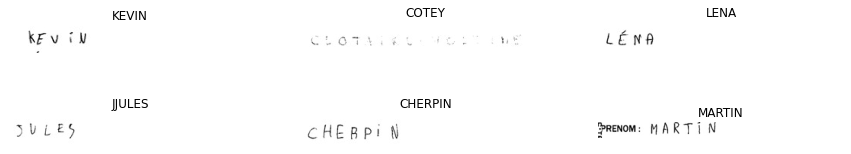

In [101]:
test = pd.read_csv('handwriting-recognition/written_name_test_v2.csv')
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = hwr_model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(number_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [102]:
test_size = 5000

In [103]:
test_x = []

for i in range(test_size):
    img_dir = 'handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [104]:
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [105]:
ty_true = train.loc[0:train_size, 'IDENTITY']

In [106]:
print(ty_true)

0        BALTHAZAR
1            SIMON
2            BENES
3          LA LOVE
4           DAPHNE
           ...    
19996     ANDREANE
19997       BROQUA
19998         LANN
19999          LEA
20000       MATHEO
Name: IDENTITY, Length: 20001, dtype: object


THIBAULT


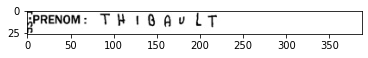

AZADI


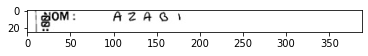

GORTCMAKOF


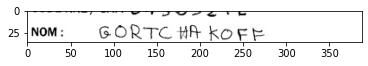

MAHENTHIAAN


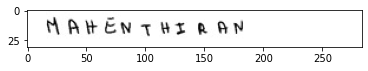

FRANEEISSSIEPH


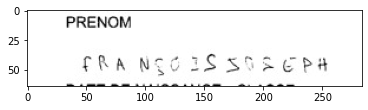

JEANNE


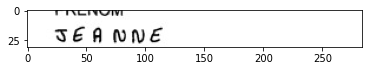

DEBORAH


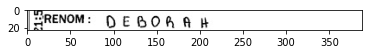

DROUES


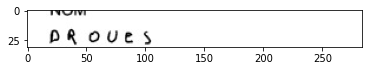

In [107]:
for i in range(8,16):
    img_dir = 'handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocess(image)
    image = image/255
    pred = hwr_model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
    print(num_to_label(decoded[0]))
    plt.show() 

# Test model on random input images from testing dataset.

CHRISTOPHE


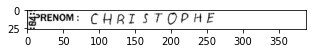

In [108]:
plt.figure(figsize=(5, 5))

img_dir = "handwriting-recognition/test_v2/test/TEST_0450.jpg"
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255
pred = hwr_model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
print(number_to_label(decoded[0]))

ADAM


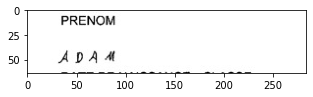

In [109]:
plt.figure(figsize=(5, 5))

img_dir = "handwriting-recognition/test_v2/test/TEST_5000.jpg"
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255
pred = hwr_model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
print(num_to_label(decoded[0]))

LOUISON


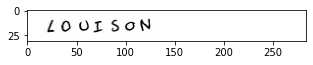

In [110]:
plt.figure(figsize=(5, 5))

img_dir = "handwriting-recognition/test_v2/test/TEST_9520.jpg"
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255
pred = hwr_model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
print(num_to_label(decoded[0]))

In [111]:
valid_x.shape

(3000, 256, 64, 1)

# Accuracy using jaro and ratio.

In [115]:
pip install python-Levenshtein

     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149870 sha256=3fa7cc60e8138e3752e6dd27fb8203bb163e1b3bbb5abbf17b796b8b280e5257
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [116]:
hwr_model.load_weights(filepath)

# predict outputs on validation images
prediction = hwr_model.predict(valid_x)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=alphabets_list[int(p)]
    total_jaro+=lv.jaro(letters, y_true[i])
    total_rati+=lv.ratio(letters, y_true[i])
out = len(out)

print('jaro : ', (total_jaro/out))
print('ratio:', total_rati/out)

jaro :  0.9636138159589116
ratio: 0.9511718114943216


In [118]:
# predict outputs on validation images
prediction = hwr_model.predict(train_x[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
i = 0
# see the results
for i, x in enumerate(out):
    print("original_text =  ", ty_true[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(alphabets_list[int(p)], end = '')
    print('\n')

original_text =   ANDRE
predicted text = ANDRE

original_text =   LILI
predicted text = LILIO

original_text =   RICK
predicted text = RICK

original_text =   ORLANNE
predicted text = ORLANNE

original_text =   EWEN
predicted text = EWEN

original_text =   BOGLARKA
predicted text = BOOLARKA

original_text =   GUST
predicted text = GUST

original_text =   LIUUT
predicted text = MIUUTY

original_text =   DJAVID
predicted text = DJAVID

original_text =   MARGAUX
predicted text = MARGAUX

original_text =   DHULU
predicted text = DHULU

original_text =   CADWAL
predicted text = CADWAL

original_text =   WATTIEZ
predicted text = WATTIEZ

original_text =   CORDON
predicted text = CORDON

original_text =   QUENTIN
predicted text = QUENTIN

original_text =   RAYAN
predicted text = RAYAN

original_text =   THOMAS
predicted text = THOMAS

original_text =   CUCHERIL
predicted text = CUCHERIL

original_text =   LOUIS
predicted text = LOUIS

original_text =   ELINE
predicted text = ELINE



In [123]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [124]:
acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']
loss = history_model.history['loss']
val_loss = history_model.history['val_loss']
epochs = range(1,len(loss)+1)

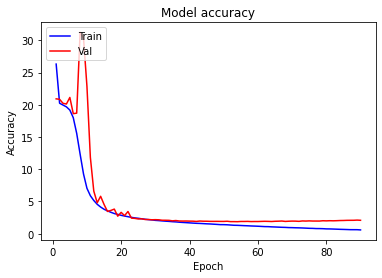

In [125]:
plotgraph(epochs, loss, val_loss)

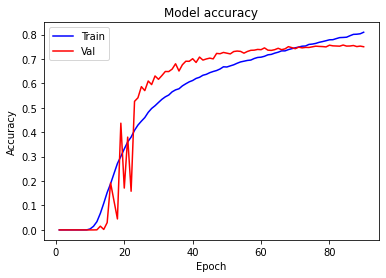

In [126]:
plotgraph(epochs, acc, val_acc)

In [128]:
# get best model index
minimum_val_loss = np.min(history_model.history['val_loss'])
best_model_index = np.where(history_model.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history_model.history['loss'][best_model_index])
best_acc = str(history_model.history['accuracy'][best_model_index])
best_val_loss = str(history_model.history['val_loss'][best_model_index])
best_val_acc = str(history_model.history['val_accuracy'][best_model_index])

In [129]:
with open('history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(train_x.shape[0]),
                                                      str(valid_x.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)